## 19-1. 프로젝트: Vocabulary Size를 변경해서 시도해보기
지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.

`(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)`

앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요.

### 1. 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


**[ 안내 ]**

**1. 모든 단어 사용**<br>
`(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)`

**2. 빈도수 상위 5,000개의 단어만 사용**<br>
`(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)`

**3. 직접 단어 개수를 설정해서 사용**<br>
위 단계에서 5000으로 제시된 num_words를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요. 최소 3가지 경우 이상을 실험해 보기를 권합니다.

>사용할 모델
> 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅

**4. 딥러닝 모델과 비교해 보기**<br>
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정 분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

**[ 루브릭 ]**
아래의 기준을 바탕으로 프로젝트를 평가합니다.

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가? -> 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가? ->	Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?	-> 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

**[ 실습 ]**

### 1. 데이터 로드 및 전처리
Reuters 데이터를 num_words에 따라 다양한 단어 수로 로드합니다.

모든 단어 사용

In [2]:
from tensorflow.keras.datasets import reuters

(x_train_all, y_train_all), (x_test_all, y_test_all) = reuters.load_data(num_words=None, test_split=0.2)

데이터 전처리 실행<br>
preprocess_data를 사용하여 x_train_tfidf와 x_test_tfidf를 생성합니다.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def preprocess_data(x_train, x_test, num_words):
    # 단어 인덱스 로드 및 디코딩 설정
    word_index = reuters.get_word_index()
    index_to_word = {value + 3: key for key, value in word_index.items()}
    index_to_word[0] = "<PAD>"
    index_to_word[1] = "<START>"
    index_to_word[2] = "<UNK>"
    index_to_word[3] = "<UNUSED>"
    
    # Token -> Words
    decoded_train = [" ".join([index_to_word.get(idx, "?") for idx in sequence]) for sequence in x_train]
    decoded_test = [" ".join([index_to_word.get(idx, "?") for idx in sequence]) for sequence in x_test]
    
    # DTM and TF-IDF
    vectorizer = CountVectorizer(max_features=num_words)
    tfidf_transformer = TfidfTransformer()
    x_train_dtm = vectorizer.fit_transform(decoded_train)
    x_test_dtm = vectorizer.transform(decoded_test)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    
    return x_train_tfidf, x_test_tfidf

# 데이터 로드
from tensorflow.keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

# 데이터 전처리 실행
x_train_tfidf, x_test_tfidf = preprocess_data(x_train, x_test, num_words=5000)

빈도수 상위 5,000개의 단어만 사용

In [4]:
(x_train_5000, y_train_5000), (x_test_5000, y_test_5000) = reuters.load_data(num_words=5000, test_split=0.2)

사용자 정의 단어 개수 설정 (예: 2,000, 7,000, 10,000)

In [5]:
(x_train_2000, y_train_2000), (x_test_2000, y_test_2000) = reuters.load_data(num_words=2000, test_split=0.2)
(x_train_7000, y_train_7000), (x_test_7000, y_test_7000) = reuters.load_data(num_words=7000, test_split=0.2)
(x_train_10000, y_train_10000), (x_test_10000, y_test_10000) = reuters.load_data(num_words=10000, test_split=0.2)

### 2. 모델 학습 및 평가
다양한 모델을 학습시키고 정확도를 평가합니다. 주요 단계는 다음과 같습니다:

공통 데이터 전처리
- 데이터는 단어 인덱스를 벡터로 변환한 후 DTM과 TF-IDF를 생성합니다.
- CountVectorizer와 TfidfTransformer를 사용합니다.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def preprocess_data(x_train, x_test, num_words):
    # Decoding 데이터
    word_index = reuters.get_word_index()
    index_to_word = {value + 3: key for key, value in word_index.items()}
    index_to_word[0] = "<PAD>"
    index_to_word[1] = "<START>"
    index_to_word[2] = "<UNK>"
    index_to_word[3] = "<UNUSED>"
    
    # Token -> Words
    decoded_train = [" ".join([index_to_word.get(idx, "?") for idx in sequence]) for sequence in x_train]
    decoded_test = [" ".join([index_to_word.get(idx, "?") for idx in sequence]) for sequence in x_test]
    
    # DTM and TF-IDF
    vectorizer = CountVectorizer(max_features=num_words)
    tfidf_transformer = TfidfTransformer()
    x_train_dtm = vectorizer.fit_transform(decoded_train)
    x_test_dtm = vectorizer.transform(decoded_test)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    
    return x_train_tfidf, x_test_tfidf

**사용 모델**<br>
아래 모델을 각각 실행합니다.

In [7]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

# Voting 구현을 위한 설정 (Voing은 'soft')
# 조건1 : 로지스틱회귀(패널티는 'L2')
log_reg = LogisticRegression(penalty='l2', random_state=0)
#조건 2: Complement Naive Bayes Classifier
cnb = ComplementNB()
#조건 3: GradientBoosting Classifier
gb = GradientBoostingClassifier(random_state=0)

# 모델 리스트
models = {
    "Naive Bayes": MultinomialNB(),
    "Complement Naive Bayes": ComplementNB(),
    "Logistic Regression": LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    "Linear SVC": LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=5, random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(),
    "VotingClassifier": VotingClassifier(estimators=[('log_reg', log_reg), ('cnb', cnb), ('gb', gb)], voting='soft')
}

# 각 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(x_train_tfidf, y_train)
    predicted = model.predict(x_test_tfidf)
    accuracy = accuracy_score(y_test, predicted)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.4f}")

Training Naive Bayes...
Naive Bayes Accuracy: 0.6732
Training Complement Naive Bayes...
Complement Naive Bayes Accuracy: 0.7707
Training Logistic Regression...
Logistic Regression Accuracy: 0.8037
Training Linear SVC...


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy: 0.7734
Training Decision Tree...
Decision Tree Accuracy: 0.6215
Training Random Forest...
Random Forest Accuracy: 0.6834
Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7649
Training VotingClassifier...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier Accuracy: 0.7930


### 3. 단어 수 변경 실험
다양한 num_words 값을 변경하며 데이터 전처리를 다시 실행합니다.

In [8]:
# 단어 수 실험 (2000, 7000, 10000)
for num_words in [2000, 7000, 10000]:
    print(f"\n=== Vocabulary Size: {num_words} ===")
    x_train_tfidf, x_test_tfidf = preprocess_data(x_train, x_test, num_words=num_words)
    for model_name, model in models.items():
        model.fit(x_train_tfidf, y_train)
        predicted = model.predict(x_test_tfidf)
        accuracy = accuracy_score(y_test, predicted)
        print(f"{model_name} Accuracy with {num_words} words: {accuracy:.4f}")


=== Vocabulary Size: 2000 ===
Naive Bayes Accuracy with 2000 words: 0.6968
Complement Naive Bayes Accuracy with 2000 words: 0.7565
Logistic Regression Accuracy with 2000 words: 0.7809


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy with 2000 words: 0.7378
Decision Tree Accuracy with 2000 words: 0.6242
Random Forest Accuracy with 2000 words: 0.7012
Gradient Boosting Accuracy with 2000 words: 0.7538


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier Accuracy with 2000 words: 0.7805

=== Vocabulary Size: 7000 ===
Naive Bayes Accuracy with 7000 words: 0.6732
Complement Naive Bayes Accuracy with 7000 words: 0.7707
Logistic Regression Accuracy with 7000 words: 0.8037


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy with 7000 words: 0.7711
Decision Tree Accuracy with 7000 words: 0.6215
Random Forest Accuracy with 7000 words: 0.6834
Gradient Boosting Accuracy with 7000 words: 0.7618


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier Accuracy with 7000 words: 0.7930

=== Vocabulary Size: 10000 ===
Naive Bayes Accuracy with 10000 words: 0.6732
Complement Naive Bayes Accuracy with 10000 words: 0.7707
Logistic Regression Accuracy with 10000 words: 0.8037


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy with 10000 words: 0.7743
Decision Tree Accuracy with 10000 words: 0.6215
Random Forest Accuracy with 10000 words: 0.6834
Gradient Boosting Accuracy with 10000 words: 0.7667


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier Accuracy with 10000 words: 0.7930


### 4. 딥러닝 모델과 비교
LSTM, GRU, 또는 1D-CNN 모델을 사용합니다.<br>
공정성을 위해 Word2Vec 등의 pretrained 모델은 사용하지 않습니다.<br>

딥러닝 모델 정의 및 학습

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Define model
def create_rnn_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(46, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model
rnn_model = create_rnn_model(num_words)
rnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate model
rnn_accuracy = rnn_model.evaluate(x_test, y_test, verbose=0)[1]
print("RNN Model Accuracy:", rnn_accuracy)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

### 5. 결과 분석
- 모델별 정확도를 그래프로 시각화하여 비교<br>

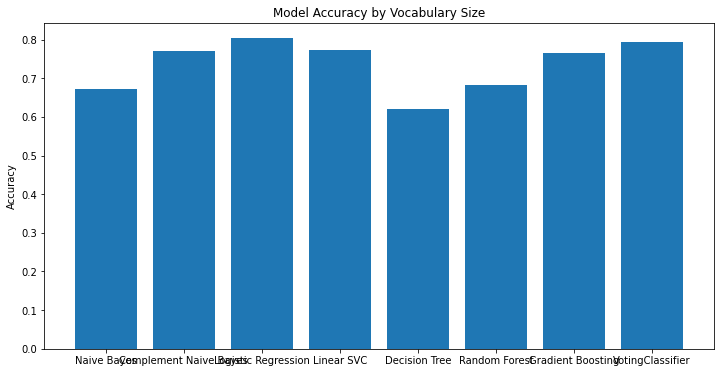

In [10]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy by Vocabulary Size")
plt.ylabel("Accuracy")
plt.show()

- 단어 수 변경에 따른 정확도 변화를 테이블로 정리합니다.

| Vocabulary Size | 2000 |
| ------------------ | ------ |
| Naive Bayes | 0.6968 |
| Complement Naive Bayes | 0.7565 |
| Logistic Regression | 0.7809 |
| Linear SVC | 0.7378 |
| Decision Tree | 0.6242 |
| Random Forest | 0.7012 |
| Gradient Boosting | 0.7538 |
| Voting Classifier | 0.7805 |

| Vocabulary Size | 7000 |
| ------------------ | ------ |
| Naive Bayes | 0.6732 |
| Complement Naive Bayes | 0.7707 |
| Logistic Regression | 0.8037 |
| Linear SVC | 0.7711 |
| Decision Tree | 0.6215 |
| Random Forest | 0.6834 |
| Gradient Boosting | 0.7618 |
| Voting Classifier | 0.7930 |

| Vocabulary Size | 10000 |
| ------------------ | ------ |
| Naive Bayes | 0.6732 |
| Complement Naive Bayes | 0.7707 |
| Logistic Regression | 0.8037 |
| Linear SVC | 0.7743 |
| Decision Tree | 0.6215 |
| Random Forest | 0.6834 |
| Gradient Boosting | 0.7667 |
| Voting Classifier | 0.7930 |


- 딥러닝과 머신러닝 모델의 성능 차이를 논의<br>
에러 발생으로 추후 진행 예정

결론
- 가장 높은 정확도인 0.8037을 보인 모델은 Logistic Regression 으로 Vocalulary Size는 7000과 10000에서 동일함. 해당 모델에서는 최적의 단어 수가 7000임
- 딥러닝과 머신러닝 모델의 성능 차이는 향후 진행 예정